# 00 - Exploração Inicial (EDA) - SRAG Hospitalizado

> Primeira passada de radar na base de SRAG 2023: entender o terreno antes de sair modelando.

---

### Objetivos desta primeira EDA

- **Entender a estrutura básica da base de SRAG 2023**  
  Tamanho, colunas, tipos, chaves, granularidade do registro (linha = caso hospitalizado).

- **Avaliar qualidade dos dados**  
  - Proporção de **missing** por variável.  
  - **Tipos** (numérico, categórico, data, texto).  
  - **Códigos** e categorias (dicionário x prática real).

- **Criar visões iniciais**  
  - **Demográficas**: idade, sexo, raça/cor, região/UF.  
  - **Desfechos**: alta, óbito, internação em UTI, suporte ventilatório.  
  - **Temporais**: evolução ao longo do ano (semanas epidemiológicas / meses).

---

### Ideia geral desta etapa

1. Carregar a base bruta e inspecionar dimensões.  
2. Padronizar tipos básicos (datas, categóricos, inteiros).  
3. Medir missing e decidir o que claramente é **peso morto** vs. **candidato a ficar**.  
4. Gerar gráficos e tabelas simples para ter a **fotografia macro** dos casos hospitalizados em 2023.  


In [26]:
# 0. Imports e configurações básicas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Aumenta o número máximo de colunas mostradas pelo pandas.
# Útil para inspecionar bases largas sem que ele corte com "..."
pd.set_option("display.max_columns", 120)

# Caminhos Utilizados
PROJECT_ROOT = Path.cwd().parent        # sobe um nível

DATA_RAW = PROJECT_ROOT / "srag_2023_analysis" / "data" / "raw"
CSV_PATH = DATA_RAW / "INFLUD23-26-06-2025.csv"

DICT_RAW = PROJECT_ROOT / "srag_2023_analysis" /  "docs" 
DICT_PATH = DICT_RAW / "dicionario_refinado_desafio_srag.xlsx"

# Controla o tamanho da amostra usada na EDA.
# 1.0 = 100% dos dados. Em máquinas mais fracas ou testes rápidos,
# pode reduzir para 0.2 (20%), 0.1 (10%), etc.
SAMPLE_FRAC = 1.0   # pode reduzir p/ 0.2, 0.1 para EDA rápida

# Semente do gerador de números aleatórios para a amostragem.
# Mantém a mesma amostra entre execuções (reprodutibilidade).
RANDOM_STATE = 42

In [27]:
# 1. Carregamento da base SRAG
# A base do Ministério da Saúde costuma vir com ; e " como separador/padrão
df_base = pd.read_csv(
    CSV_PATH,
    sep=";",
    dtype=str,           # carregamos tudo como string primeiro por segurança
    low_memory=False
)

print("Shape original:", df_base.shape)

if 0 < SAMPLE_FRAC < 1:
    df_base = df_base.sample(frac=SAMPLE_FRAC, random_state=RANDOM_STATE)
    print("Shape após amostragem:", df_base.shape)

df_base.head()

Shape original: (279453, 194)


,NU_NOTIFIC,DT_NOTIFIC,SEM_NOT,DT_SIN_PRI,SEM_PRI,SG_UF_NOT,ID_REGIONA,CO_REGIONA,ID_MUNICIP,CO_MUN_NOT,CS_SEXO,DT_NASC,NU_IDADE_N,TP_IDADE,COD_IDADE,CS_GESTANT,CS_RACA,CS_ETINIA,CS_ESCOL_N,ID_PAIS,CO_PAIS,SG_UF,ID_RG_RESI,CO_RG_RESI,ID_MN_RESI,CO_MUN_RES,CS_ZONA,NOSOCOMIAL,AVE_SUINO,FEBRE,TOSSE,GARGANTA,DISPNEIA,DESC_RESP,SATURACAO,DIARREIA,VOMITO,OUTRO_SIN,OUTRO_DES,FATOR_RISC,PUERPERA,CARDIOPATI,HEMATOLOGI,SIND_DOWN,HEPATICA,ASMA,DIABETES,NEUROLOGIC,PNEUMOPATI,IMUNODEPRE,RENAL,OBESIDADE,OBES_IMC,OUT_MORBI,MORB_DESC,TABAG,VACINA,DT_UT_DOSE,MAE_VAC,DT_VAC_MAE,...,POS_AN_FLU,TP_FLU_AN,POS_AN_OUT,AN_SARS2,AN_VSR,AN_PARA1,AN_PARA2,AN_PARA3,AN_ADENO,AN_OUTRO,DS_AN_OUT,TP_AM_SOR,SOR_OUT,DT_CO_SOR,TP_SOR,OUT_SOR,DT_RES,RES_IGG,RES_IGM,RES_IGA,POV_CT,TP_POV_CT,TEM_CPF,ESTRANG,VACINA_COV,DOSE_1_COV,DOSE_2_COV,DOSE_REF,DOSE_2REF,DOSE_ADIC,DOS_RE_BI,FAB_COV_1,FAB_COV_2,FAB_COVRF,FAB_COVRF2,FAB_ADIC,FAB_RE_BI,LOTE_1_COV,LOTE_2_COV,LOTE_REF,LOTE_REF2,LOTE_ADIC,LOT_RE_BI,FNT_IN_COV,TRAT_COV,TIPO_TRAT,DT_TRT_COV,OUT_TRAT,SURTO_SG,CO_DETEC,VG_OMS,VG_OMSOUT,VG_LIN,VG_MET,VG_METOUT,VG_DTRES,VG_ENC,VG_REINF,VG_CODEST,REINF
0,316004370301,2023-02-07,06,2023-02-05,06,SP,GVE VII SANTO ANDRE,1332,SAO CAETANO DO SUL,354880,F,1941-06-30,81,3,3081,6,1,NaN,1,BRASIL,1,SP,GVE VII SANTO ANDRE,1332,SAO CAETANO DO SUL,354880,1,2,2,NaN,NaN,NaN,1,NaN,NaN,NaN,1,1,RNC,1,NaN,1,NaN,NaN,NaN,NaN,1,1,NaN,NaN,NaN,NaN,NaN,1,ACAMADA HA 12 ANOS,NaN,2,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,1,2,1,10/03/2021,07/04/2021,06/04/2022,06/04/2022,NaN,NaN,86 - COVID-19 SINOVAC/BUTANTAN - CORONAVAC,86 - COVID-19 SINOVAC/BUTANTAN - CORONAVAC,88 - COVID-19 JANSSEN - AD26.COV2.S,88 - COVID-19 JANSSEN - AD26.COV2.S,NaN,NaN,202010034,210083,210F21A,210F21A,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
1,316153805701,2023-02-28,09,2023-01-17,03,SP,GVE VII SANTO ANDRE,1332,SAO CAETANO DO SUL,354880,M,1933-12-10,89,3,3089,6,1,NaN,1,BRASIL,1,SP,GVE VII SANTO ANDRE,1332,SAO CAETANO DO SUL,354880,1,2,2,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,1,QUEDA DO ESTADO GERAL,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NEO PROSTATA/HIPOTIREOIDISMO,NaN,2,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,1,2,1,12/02/2021,05/04/2021,13/10/2021,NaN,NaN,NaN,86 - COVID-19 SINOVAC/BUTANTAN - CORONAVAC,86 - COVID-19 SINOVAC/BUTANTAN - CORONAVAC,86 - COVID-19 SINOVAC/BUTANTAN - CORONAVAC,NaN,NaN,NaN,202010034,210062,210448,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
2,316321420027,2023-05-02,18,2023-04-14,15,PR,02RS METROPOLITANA,1356,CURITIBA,410690,F,1943-06-04,78,3,3078,5,1,NaN,9,BRASIL,1,PR,02RS METROPOLITANA,1356,CURITIBA,410690,1,2,2,NaN,1,1,1,NaN,2,NaN,NaN,1,"CEFALEIA, ASTENIA",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,HIPERTENSAO ARTERIAL,NaN,2,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,1,2,1,17/03/2021,07/04/2021,NaN,NaN,NaN,NaN,SINOVAC,NaN,NaN,NaN,NaN,NaN,210056,210129,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
3,316384665515,2023-03-09,10,2023-03-05,10,SP,GVE VII SANTO ANDRE,1332,SAO CAETANO DO SUL,354880,F,1916-04-29,105,3,3105,6,1,NaN,1,BRASIL,1,SP,GVE VII SANTO ANDRE,1332,SAO CAETANO DO SUL,354880,1,2,2,NaN,1,NaN,1,1,1,NaN,NaN,NaN,NaN,1,NaN,1,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,1,2,1,09/02/2021,05/03/2021,08/09/2021,NaN,NaN,NaN,86 - COVID-19 SINOVAC/BUTANTAN - CORONAVAC,86 - COVID-19 SINOVAC/BUTANTAN - CORONAVAC,86 - COVID-19 SINOVAC/BUTANTAN - CORONAVAC,NaN,NaN,NaN,210010,210046,210448,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
4,31643223416015,2023-01-21,03,2023-01-17,03,MG,JUIZ DE FORA,1452,JUIZ DE FORA,313670,F,1927-01-05,95,3,3095,5,1,NaN,9,BRASIL,1,MG,JUIZ DE F

In [28]:
# 2. Carregamento do dicionário refinado

dict_df = pd.read_excel(DICT_PATH)

dict_df.head()

,Variável (CSV),Variável (DBF - dicionário),Nome do campo (Ficha),Tipo,Categoria / Valores,Descrição,Características
0,NU_NOTIFIC,NU_NOTIFIC,Nº,Varchar2(12),NaN,Número do registro,Campo Interno \n \nNúmero sequencial gerado au...
1,DT_NOTIFIC,DT_NOTIFIC,1-Data do preenchimento da ficha de \nnotificação,Date \nDD/MM/AAAA,NaN,Data de \npreenchimento da \nficha de \nnotifi...,Campo Obrigatório \n \nData deve ser <= a data...
2,SEM_NOT,SEM_NOT,Semana Epidemiológica do \npreenchimento da fi...,Varchar2(6),NaN,Semana \nEpidemiológica do \npreenchimento da ...,Campo Interno \n \nCalculado a partir da data ...
3,DT_SIN_PRI,DT_SIN_PRI,2-Data de 1ºs sintomas,Date \nDD/MM/AAAA,NaN,Data de 1º \nsintomas do caso.,Campo Obrigatório \n \nData deve ser <= a data...
4,SEM_PRI,SEM_PRI,Semana Epidemiológica dos Primeiros \nSintomas,Varchar2(6),NaN,Semana \nEpidemiológica do \ninício dos sintomas.,Campo Interno \n \nCalculado a partir da data ...


In [29]:
# 2.1. Função para construir dict código -> descrição a partir do dicionário

def build_cat_map(dict_df, var_csv):
    """
    Cria um mapping {codigo: descricao} para uma variável categórica
    a partir do dicionário refinado.

    var_csv: nome exato da coluna no CSV (coluna 'Variável (CSV)' do dicionário).
    """
    linha = dict_df[dict_df["Variável (CSV)"] == var_csv]
    if linha.empty:
        # variável não encontrada no dicionário
        return {}

    raw = str(linha["Categoria / Valores"].iloc[0])
    # Se não tiver categorias definidas (NaN no dicionário), retorna vazio
    if raw == "nan":
        return {}

    # Cada linha costuma estar separada por quebra de linha: "1-Cura \n2-Óbito \n..."
    linhas = [l.strip() for l in raw.split("\n") if l.strip()]
    mapping = {}

    for l in linhas:
        # Exemplo de linha: "1-Cura", "2-Óbito", "3- Óbito por outras causas"
        if "-" in l:
            code, desc = l.split("-", 1)
            mapping[code.strip()] = desc.strip()

    return mapping

In [30]:
df = df_base.copy()

In [31]:
# 2.2. Definir variáveis categóricas de interesse e criar mappings

cat_cols = [
    "CS_SEXO",
    "CS_GESTANT",
    "CS_RACA",
    "CS_ESCOL_N",
    "CS_ZONA",
    "EVOLUCAO",
    "UTI",
    "SUPORT_VEN",
    "SG_UF"
]

# Garante que só tentamos criar mapping para colunas que existem no CSV
cat_cols = [c for c in cat_cols if c in df.columns]

category_mappings = {}

for col in cat_cols:
    mapping = build_cat_map(dict_df, col)
    category_mappings[col] = mapping
    print(f"\n=== {col} ===")
    print(mapping)


=== CS_SEXO ===
{'M': 'Masculino', 'F': 'Feminino', 'I': 'Ignorado'}

=== CS_GESTANT ===
{'1': '1º Trimestre', '2': '2º Trimestre', '3': '3º Trimestre', '4': 'Idade Gestacional Ignorada', '5': 'Não', '6': 'Não se aplica', '9': 'Ignorado'}

=== CS_RACA ===
{'1': 'Branca', '2': 'Preta', '3': 'Amarela', '4': 'Parda', '5': 'Indígena', '9': 'Ignorado'}

=== CS_ESCOL_N ===
{'0': 'Sem escolaridade/', '1': 'Fundamental 1º ciclo (1ª a', '2': 'Fundamental 2º ciclo (6ª a', '3': 'Médio (1º ao 3º ano)', '4': 'Superior', '5': 'Não se aplica', '9': 'Ignorado'}

=== CS_ZONA ===
{'1': 'Urbana', '2': 'Rural', '3': 'Periurbana', '9': 'Ignorado'}

=== EVOLUCAO ===
{'1': 'Cura', '2': 'Óbito', '3': 'Óbito por outras causas', '9': 'Ignorado'}

=== UTI ===
{'1': 'Sim', '2': 'Não', '9': 'Ignorado'}

=== SUPORT_VEN ===
{'1': 'Sim, invasivo', '2': 'Sim, não invasivo', '3': 'Não', '9': 'Ignorado'}

=== SG_UF ===
{}


In [32]:
# 2.3. Função para aplicar o mapping de código -> descrição no df

def add_label_column(df, col, mapping, suffix="_label", include_code=True):
    """
    Cria uma nova coluna com rótulo humano a partir da coluna codificada.

    df         : DataFrame original
    col        : nome da coluna com o código (ex: 'EVOLUCAO')
    mapping    : dict {codigo: descricao}
    suffix     : sufixo do novo nome de coluna (default: '_label')
    include_code : se True, retorna 'codigo - descricao'; se False, só descricao

    Retorna o nome da nova coluna criada.
    """
    def _map_value(v):
        if pd.isna(v):
            return "Missing"
        code = str(v)
        desc = mapping.get(code, "")
        if not desc:
            # código fora do dicionário → deixa explícito
            return f"{code} - (não mapeado)"
        if include_code:
            return f"{code} - {desc}"
        return desc

    new_col = col + suffix
    df[new_col] = df[col].map(_map_value)
    return new_col

In [33]:
# 3.7 Criar colunas *_label no df usando os mappings do dicionário

label_cols = []

for col in cat_cols:
    mapping = category_mappings.get(col, {})
    if not mapping:
        print(f"[AVISO] Sem mapping no dicionário para {col}, pulando.")
        continue
    
    new_col = add_label_column(df, col, mapping, suffix="_label", include_code=True)
    label_cols.append(new_col)
    print(f"Criada coluna: {new_col}")

print("\nColunas de rótulo criadas:")
print(label_cols)

Criada coluna: CS_SEXO_label
Criada coluna: CS_GESTANT_label
Criada coluna: CS_RACA_label
Criada coluna: CS_ESCOL_N_label
Criada coluna: CS_ZONA_label
Criada coluna: EVOLUCAO_label
Criada coluna: UTI_label
Criada coluna: SUPORT_VEN_label
[AVISO] Sem mapping no dicionário para SG_UF, pulando.

Colunas de rótulo criadas:
['CS_SEXO_label', 'CS_GESTANT_label', 'CS_RACA_label', 'CS_ESCOL_N_label', 'CS_ZONA_label', 'EVOLUCAO_label', 'UTI_label', 'SUPORT_VEN_label']


In [34]:
# 3.8 Inspeção rápida: códigos x labels

for col, lab_col in zip(cat_cols, label_cols):
    print(f"\n=== {col} x {lab_col} ===")
    display(
        df[[col, lab_col]]
        .drop_duplicates()
        .sort_values(col)
        .head(15)
    )


=== CS_SEXO x CS_SEXO_label ===


,CS_SEXO,CS_SEXO_label
0,F,F - Feminino
3705,I,I - Ignorado
1,M,M - Masculino



=== CS_GESTANT x CS_GESTANT_label ===


,CS_GESTANT,CS_GESTANT_label
1760,0,0 - (não mapeado)
111,1,1 - 1º Trimestre
1106,2,2 - 2º Trimestre
26,3,3 - 3º Trimestre
985,4,4 - Idade Gestacional Ignorada
2,5,5 - Não
0,6,6 - Não se aplica
54,9,9 - Ignorado



=== CS_RACA x CS_RACA_label ===


,CS_RACA,CS_RACA_label
0,1,1 - Branca
70,2,2 - Preta
109,3,3 - Amarela
7,4,4 - Parda
27,5,5 - Indígena
23,9,9 - Ignorado



=== CS_ESCOL_N x CS_ESCOL_N_label ===


,CS_ESCOL_N,CS_ESCOL_N_label
21,0,0 - Sem escolaridade/
0,1,1 - Fundamental 1º ciclo (1ª a
6,2,2 - Fundamental 2º ciclo (6ª a
9,3,3 - Médio (1º ao 3º ano)
91,4,4 - Superior
8,5,5 - Não se aplica
2,9,9 - Ignorado
13,NaN,Missing



=== CS_ZONA x CS_ZONA_label ===


,CS_ZONA,CS_ZONA_label
0,1,1 - Urbana
10,2,2 - Rural
248,3,3 - Periurbana
39,9,9 - Ignorado
7,NaN,Missing



=== EVOLUCAO x EVOLUCAO_label ===


,EVOLUCAO,EVOLUCAO_label
2,1,1 - Cura
0,2,2 - Óbito
27,3,3 - Óbito por outras causas
21,9,9 - Ignorado
37,NaN,Missing



=== UTI x UTI_label ===


,UTI,UTI_label
4,1,1 - Sim
0,2,2 - Não
86,9,9 - Ignorado
6,NaN,Missing



=== SUPORT_VEN x SUPORT_VEN_label ===


,SUPORT_VEN,SUPORT_VEN_label
4,1,"1 - Sim, invasivo"
2,2,"2 - Sim, não invasivo"
0,3,3 - Não
48,9,9 - Ignorado
13,NaN,Missing



=== CS_SEXO x CS_SEXO_label ===


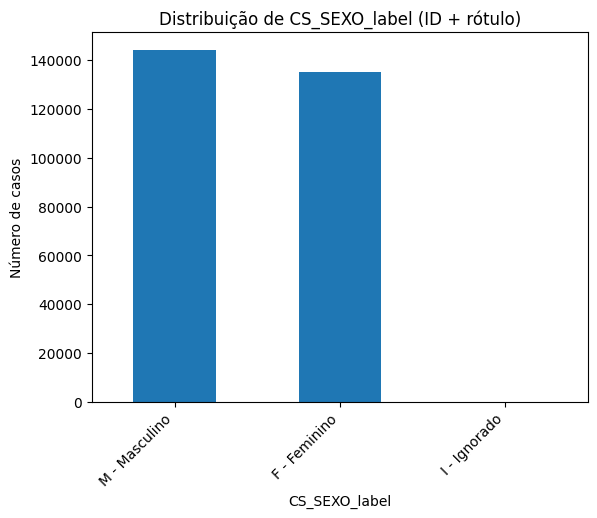


=== CS_GESTANT x CS_GESTANT_label ===


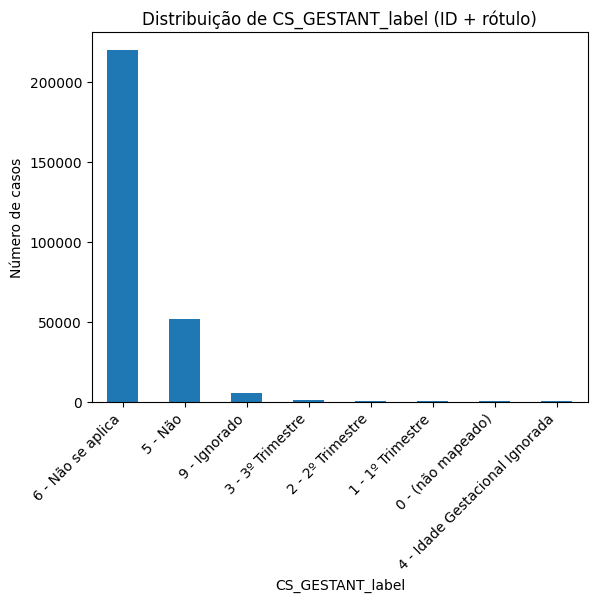


=== CS_RACA x CS_RACA_label ===


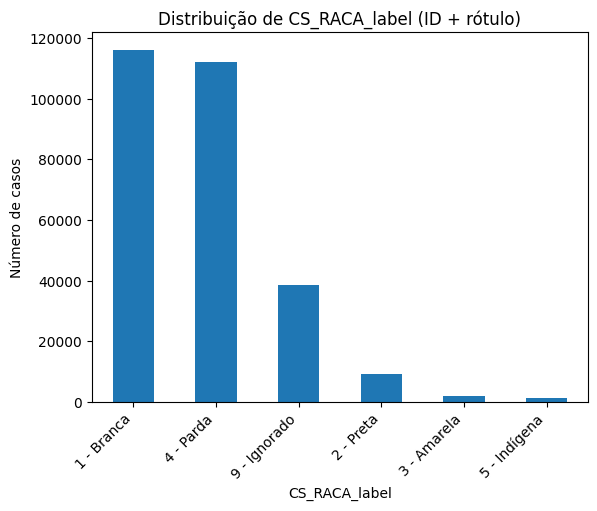


=== CS_ESCOL_N x CS_ESCOL_N_label ===


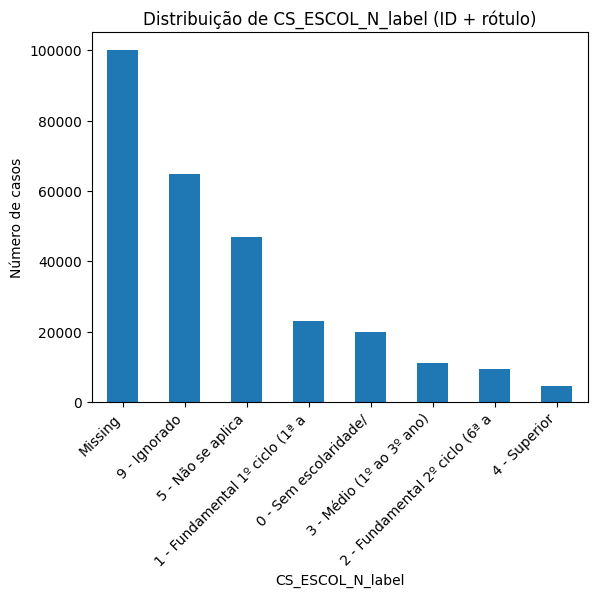


=== CS_ZONA x CS_ZONA_label ===


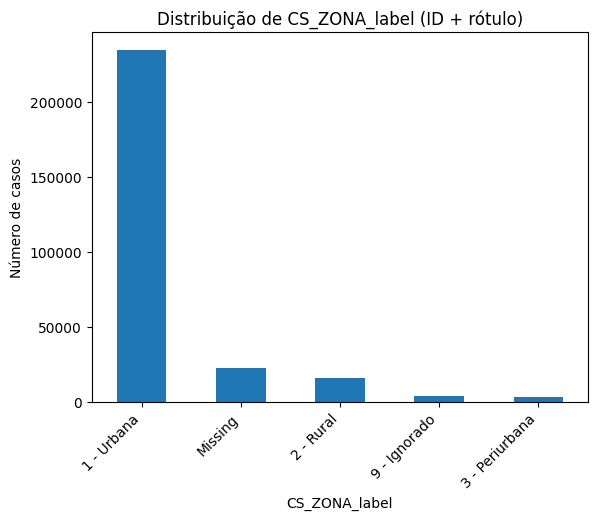


=== EVOLUCAO x EVOLUCAO_label ===


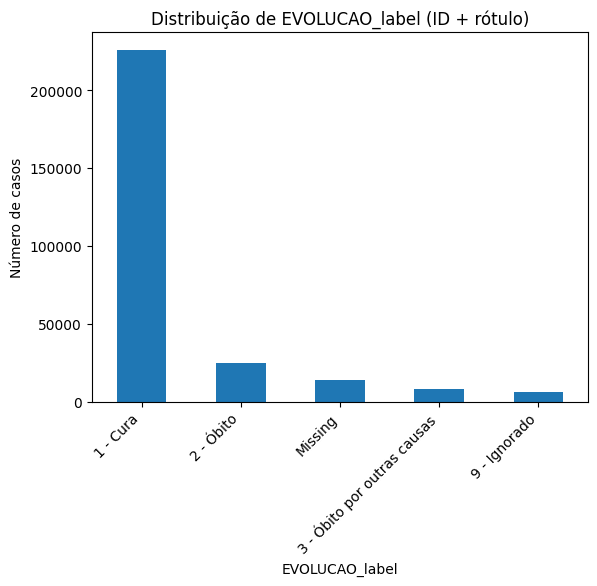


=== UTI x UTI_label ===


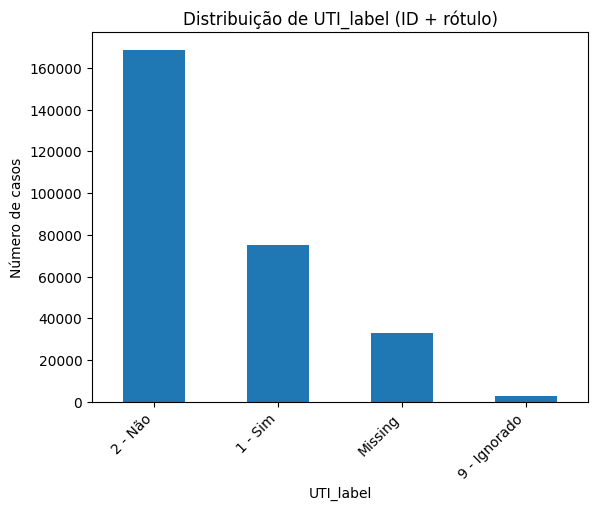


=== SUPORT_VEN x SUPORT_VEN_label ===


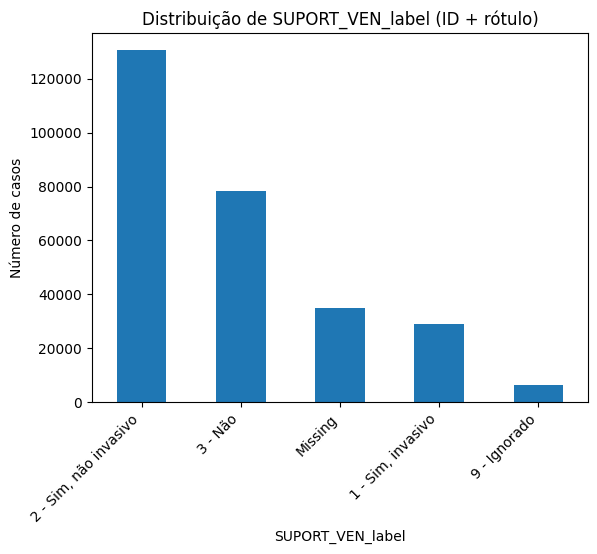

In [35]:
import matplotlib.pyplot as plt


for col, lab_col in zip(cat_cols, label_cols):
    print(f"\n=== {col} x {lab_col} ===") 
    if lab_col in df.columns:
        (
            df[lab_col]
            .value_counts()
            .plot(kind="bar")
        )
        plt.xticks(rotation=45, ha="right")
        plt.ylabel("Número de casos")
        plt.title(f"Distribuição de {lab_col} (ID + rótulo)")
        plt.show()

In [36]:
# 3. Visão estrutural da base

n_rows, n_cols = df_base.shape
print(f"Número de linhas: {n_rows:,}")
print(f"Número de colunas: {n_cols}")

print("\nTipos brutos (tudo string por enquanto):")
display(df_base.dtypes.value_counts())

memory_mb = df_base.memory_usage(deep=True).sum() / 1024**2
print(f"\nUso de memória aproximado: {memory_mb:,.2f} MB")

df_base.head()

Número de linhas: 279,453
Número de colunas: 194

Tipos brutos (tudo string por enquanto):


object    194
Name: count, dtype: int64


Uso de memória aproximado: 2,306.88 MB


,NU_NOTIFIC,DT_NOTIFIC,SEM_NOT,DT_SIN_PRI,SEM_PRI,SG_UF_NOT,ID_REGIONA,CO_REGIONA,ID_MUNICIP,CO_MUN_NOT,CS_SEXO,DT_NASC,NU_IDADE_N,TP_IDADE,COD_IDADE,CS_GESTANT,CS_RACA,CS_ETINIA,CS_ESCOL_N,ID_PAIS,CO_PAIS,SG_UF,ID_RG_RESI,CO_RG_RESI,ID_MN_RESI,CO_MUN_RES,CS_ZONA,NOSOCOMIAL,AVE_SUINO,FEBRE,TOSSE,GARGANTA,DISPNEIA,DESC_RESP,SATURACAO,DIARREIA,VOMITO,OUTRO_SIN,OUTRO_DES,FATOR_RISC,PUERPERA,CARDIOPATI,HEMATOLOGI,SIND_DOWN,HEPATICA,ASMA,DIABETES,NEUROLOGIC,PNEUMOPATI,IMUNODEPRE,RENAL,OBESIDADE,OBES_IMC,OUT_MORBI,MORB_DESC,TABAG,VACINA,DT_UT_DOSE,MAE_VAC,DT_VAC_MAE,...,POS_AN_FLU,TP_FLU_AN,POS_AN_OUT,AN_SARS2,AN_VSR,AN_PARA1,AN_PARA2,AN_PARA3,AN_ADENO,AN_OUTRO,DS_AN_OUT,TP_AM_SOR,SOR_OUT,DT_CO_SOR,TP_SOR,OUT_SOR,DT_RES,RES_IGG,RES_IGM,RES_IGA,POV_CT,TP_POV_CT,TEM_CPF,ESTRANG,VACINA_COV,DOSE_1_COV,DOSE_2_COV,DOSE_REF,DOSE_2REF,DOSE_ADIC,DOS_RE_BI,FAB_COV_1,FAB_COV_2,FAB_COVRF,FAB_COVRF2,FAB_ADIC,FAB_RE_BI,LOTE_1_COV,LOTE_2_COV,LOTE_REF,LOTE_REF2,LOTE_ADIC,LOT_RE_BI,FNT_IN_COV,TRAT_COV,TIPO_TRAT,DT_TRT_COV,OUT_TRAT,SURTO_SG,CO_DETEC,VG_OMS,VG_OMSOUT,VG_LIN,VG_MET,VG_METOUT,VG_DTRES,VG_ENC,VG_REINF,VG_CODEST,REINF
0,316004370301,2023-02-07,06,2023-02-05,06,SP,GVE VII SANTO ANDRE,1332,SAO CAETANO DO SUL,354880,F,1941-06-30,81,3,3081,6,1,NaN,1,BRASIL,1,SP,GVE VII SANTO ANDRE,1332,SAO CAETANO DO SUL,354880,1,2,2,NaN,NaN,NaN,1,NaN,NaN,NaN,1,1,RNC,1,NaN,1,NaN,NaN,NaN,NaN,1,1,NaN,NaN,NaN,NaN,NaN,1,ACAMADA HA 12 ANOS,NaN,2,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,1,2,1,10/03/2021,07/04/2021,06/04/2022,06/04/2022,NaN,NaN,86 - COVID-19 SINOVAC/BUTANTAN - CORONAVAC,86 - COVID-19 SINOVAC/BUTANTAN - CORONAVAC,88 - COVID-19 JANSSEN - AD26.COV2.S,88 - COVID-19 JANSSEN - AD26.COV2.S,NaN,NaN,202010034,210083,210F21A,210F21A,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
1,316153805701,2023-02-28,09,2023-01-17,03,SP,GVE VII SANTO ANDRE,1332,SAO CAETANO DO SUL,354880,M,1933-12-10,89,3,3089,6,1,NaN,1,BRASIL,1,SP,GVE VII SANTO ANDRE,1332,SAO CAETANO DO SUL,354880,1,2,2,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,1,QUEDA DO ESTADO GERAL,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NEO PROSTATA/HIPOTIREOIDISMO,NaN,2,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,1,2,1,12/02/2021,05/04/2021,13/10/2021,NaN,NaN,NaN,86 - COVID-19 SINOVAC/BUTANTAN - CORONAVAC,86 - COVID-19 SINOVAC/BUTANTAN - CORONAVAC,86 - COVID-19 SINOVAC/BUTANTAN - CORONAVAC,NaN,NaN,NaN,202010034,210062,210448,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
2,316321420027,2023-05-02,18,2023-04-14,15,PR,02RS METROPOLITANA,1356,CURITIBA,410690,F,1943-06-04,78,3,3078,5,1,NaN,9,BRASIL,1,PR,02RS METROPOLITANA,1356,CURITIBA,410690,1,2,2,NaN,1,1,1,NaN,2,NaN,NaN,1,"CEFALEIA, ASTENIA",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,HIPERTENSAO ARTERIAL,NaN,2,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,1,2,1,17/03/2021,07/04/2021,NaN,NaN,NaN,NaN,SINOVAC,NaN,NaN,NaN,NaN,NaN,210056,210129,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
3,316384665515,2023-03-09,10,2023-03-05,10,SP,GVE VII SANTO ANDRE,1332,SAO CAETANO DO SUL,354880,F,1916-04-29,105,3,3105,6,1,NaN,1,BRASIL,1,SP,GVE VII SANTO ANDRE,1332,SAO CAETANO DO SUL,354880,1,2,2,NaN,1,NaN,1,1,1,NaN,NaN,NaN,NaN,1,NaN,1,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,1,2,1,09/02/2021,05/03/2021,08/09/2021,NaN,NaN,NaN,86 - COVID-19 SINOVAC/BUTANTAN - CORONAVAC,86 - COVID-19 SINOVAC/BUTANTAN - CORONAVAC,86 - COVID-19 SINOVAC/BUTANTAN - CORONAVAC,NaN,NaN,NaN,210010,210046,210448,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
4,31643223416015,2023-01-21,03,2023-01-17,03,MG,JUIZ DE FORA,1452,JUIZ DE FORA,313670,F,1927-01-05,95,3,3095,5,1,NaN,9,BRASIL,1,MG,JUIZ DE F

In [37]:
# 4. Conferência rápida com o dicionário (alinhamento de colunas)

cols_data = set(df_base.columns)
cols_dict = set(dict_df["Variável (CSV)"])

print("Colunas no CSV que não estão no dicionário:")
display(sorted(cols_data - cols_dict))

print("\nColunas no dicionário que não estão no CSV:")
display(sorted(cols_dict - cols_data))

Colunas no CSV que não estão no dicionário:


[]


Colunas no dicionário que não estão no CSV:


[]

In [40]:
# 5. Missing por coluna (overview)

def missing_table(dataframe, top_n=40):
    """
    Retorna tabela com n_missing e % missing para cada coluna,
    ordenada do maior para o menor % missing.
    """
    n_rows = len(dataframe)
    miss = dataframe.isna().sum().reset_index()
    miss.columns = ["coluna", "n_missing"]
    miss["pct_missing"] = miss["n_missing"] / n_rows * 100
    miss = miss.sort_values("pct_missing", ascending=False)
    return miss.head(top_n)

missing_info = missing_table(df, top_n=1000)
missing_info

,coluna,n_missing,pct_missing
55,TABAG,279453,100.0
119,DT_RT_VGM,279453,100.0
115,PAIS_VGM,279453,100.0
117,LO_PS_VGM,279453,100.0
191,VG_REINF,279453,100.0
...,...,...,...
197,CS_ESCOL_N_label,0,0.0
198,CS_ZONA_label,0,0.0
199,EVOLUCAO_label,0,0.0
200,UTI_label,0,0.0


Escolha das Variaveis Principais para Analise

In [41]:
# 6. Variáveis principais para análise inicial

# Categóricas de interesse (ajustar se precisar)
cat_cols = [
    "CS_SEXO_label",
    "CS_GESTANT_label",
    "CS_RACA_label",
    "CS_ESCOL_N_label",
    "CS_ZONA_label",
    "EVOLUCAO_label",
    "UTI_label",
    "SUPORT_VEN_label",
    "SG_UF_label"
]

# Filtra só as que realmente existem na base
cat_cols = [c for c in cat_cols if c in df.columns]
cat_cols

['CS_SEXO_label',
 'CS_GESTANT_label',
 'CS_RACA_label',
 'CS_ESCOL_N_label',
 'CS_ZONA_label',
 'EVOLUCAO_label',
 'UTI_label',
 'SUPORT_VEN_label']

In [42]:
# 7. Perfil básico das categóricas

def freq_table(series, max_levels=10):
    """
    Retorna contagem e % para uma série categórica.
    Inclui NaN como categoria.
    """
    vc = series.value_counts(dropna=False)
    vc = vc.head(max_levels)
    pct = (vc / len(series) * 100).round(2)
    table = pd.DataFrame({"categoria": vc.index, "contagem": vc.values, "pct": pct.values})
    return table

for col in cat_cols:
    print(f"\n=== {col} ===")
    display(freq_table(df[col]))


=== CS_SEXO_label ===


,categoria,contagem,pct
0,M - Masculino,144280,51.63
1,F - Feminino,135153,48.36
2,I - Ignorado,20,0.01



=== CS_GESTANT_label ===


,categoria,contagem,pct
0,6 - Não se aplica,220242,78.81
1,5 - Não,51802,18.54
2,9 - Ignorado,5291,1.89
3,3 - 3º Trimestre,1043,0.37
4,2 - 2º Trimestre,480,0.17
5,1 - 1º Trimestre,309,0.11
6,0 - (não mapeado),181,0.06
7,4 - Idade Gestacional Ignorada,105,0.04



=== CS_RACA_label ===


,categoria,contagem,pct
0,1 - Branca,116075,41.54
1,4 - Parda,112058,40.10
2,9 - Ignorado,38601,13.81
3,2 - Preta,9380,3.36
4,3 - Amarela,2008,0.72
5,5 - Indígena,1331,0.48



=== CS_ESCOL_N_label ===


,categoria,contagem,pct
0,Missing,100107,35.82
1,9 - Ignorado,64882,23.22
2,5 - Não se aplica,46865,16.77
3,1 - Fundamental 1º ciclo (1ª a,22918,8.20
4,0 - Sem escolaridade/,19846,7.10
5,3 - Médio (1º ao 3º ano),10977,3.93
6,2 - Fundamental 2º ciclo (6ª a,9268,3.32
7,4 - Superior,4590,1.64



=== CS_ZONA_label ===


,categoria,contagem,pct
0,1 - Urbana,234799,84.02
1,Missing,22329,7.99
2,2 - Rural,15971,5.72
3,9 - Ignorado,3454,1.24
4,3 - Periurbana,2900,1.04



=== EVOLUCAO_label ===


,categoria,contagem,pct
0,1 - Cura,226151,80.93
1,2 - Óbito,24944,8.93
2,Missing,13980,5.00
3,3 - Óbito por outras causas,8301,2.97
4,9 - Ignorado,6077,2.17



=== UTI_label ===


,categoria,contagem,pct
0,2 - Não,168535,60.31
1,1 - Sim,75007,26.84
2,Missing,33070,11.83
3,9 - Ignorado,2841,1.02



=== SUPORT_VEN_label ===


,categoria,contagem,pct
0,"2 - Sim, não invasivo",130506,46.70
1,3 - Não,78473,28.08
2,Missing,34829,12.46
3,"1 - Sim, invasivo",29190,10.45
4,9 - Ignorado,6455,2.31


Etapa de Engenharia de Variaveis

In [59]:
df_engenharia = df

In [60]:
# Distribuição de Variaveis Nulas 
missing = missing_info
missing['pct_missing'].describe()
bins = [0, 1, 5, 20, 50, 80, 95, 100, 101]
labels = ["0-1","1-5","5-20","20-50","50-80","80-95","95-100","100+"]
missing['range'] = pd.cut(missing['pct_missing'], bins=bins, labels=labels, include_lowest=True, right=False)
missing['range'].value_counts().sort_index()

range
0-1       34
1-5        4
5-20      31
20-50     16
50-80     30
80-95     23
95-100    57
100+       7
Name: count, dtype: int64

Vemos acima que existem 7 colunas com 100% das celulas completamente nulas e 
57 colunas entre 95% e 100% nulas

In [61]:
cols_drop_hard = [
    "AN_ADENO", "AN_OUTRO", "AN_PARA1", "AN_PARA2", "AN_PARA3", "AN_VSR",
    "CLASSI_OUT",
    "CO_PS_VGM", "CS_ETINIA",
    "DOSE_ADIC",
    "DS_AN_OUT", "DS_PCR_OUT",
    "DT_1_DOSE", "DT_2_DOSE", "DT_CO_SOR", "DT_DOSEUNI", "DT_RES",
    "DT_RT_VGM", "DT_TRT_COV", "DT_UT_DOSE", "DT_VAC_MAE", "DT_VGM",
    "FAB_ADIC",
    "FLUASU_OUT", "FLUBLI_OUT",
    "LOTE_ADIC", "LO_PS_VGM",
    "OBES_IMC",
    "OUT_AMOST", "OUT_ANIM", "OUT_ANTIV", "OUT_SOR", "OUT_TRAT",
    "PAC_COCBO", "PAC_DSCBO", "PAIS_VGM",
    "PCR_ADENO", "PCR_BOCA", "PCR_FLUASU", "PCR_FLUBLI",
    "PCR_METAP", "PCR_OUTRO",
    "PCR_PARA1", "PCR_PARA2", "PCR_PARA3", "PCR_PARA4",
    "SOR_OUT",
    "TABAG",
    "TIPO_TRAT", "TOMO_OUT",
    "TP_AM_SOR", "TP_FLU_AN", "TP_FLU_PCR", "TP_POV_CT", "TP_SOR",
    "VG_CODEST", "VG_DTRES", "VG_ENC", "VG_LIN", "VG_MET",
    "VG_METOUT", "VG_OMS", "VG_OMSOUT", "VG_REINF",
]
df_engenharia = df_engenharia.drop(columns=cols_drop_hard)

### Por que essas especificamente?

> **Ideia-guia:** são campos com **cobertura ruim**, **uso prático quase nulo** e/ou **granularidade fina demais** pro objetivo do produto. Viram ruído, não sinal.

---

#### 1. Viagem / reinfecção / variante

**Colunas:**

DT_RT_VGM, PAIS_VGM, LO_PS_VGM, CO_PS_VGM, DT_VGM,  
VG_REINF, VG_OMS, VG_LIN, VG_MET, VG_METOUT,  
VG_OMSOUT, VG_CODEST, VG_DTRES, VG_ENC  

**Motivo para cortar:**

- Campos teoricamente ótimos para **vigilância genômica e de variantes**.  
- Na prática, estão **quase todos vazios**.  
- Bons para um **estudo específico de variantes** com outro pipeline; péssimos para um **modelo geral de SRAG** (viram só missing e complexidade extra).

---

#### 2. Testes super específicos (PCR/antígeno) de vírus raros / “outros”

**Colunas:**

AN_PARA*, AN_ADENO, AN_VSR, AN_OUTRO,  
PCR_PARA*, PCR_ADENO, PCR_METAP, PCR_FLUASU, PCR_FLUBLI,  
PCR_BOCA, PCR_OUTRO, FLUASU_OUT, FLUBLI_OUT,  
DS_AN_OUT, DS_PCR_OUT,  
SOR_OUT, OUT_SOR,  
TP_FLU_AN, TP_FLU_PCR, TP_SOR, TP_AM_SOR, DT_CO_SOR  

**Motivo para cortar:**

- Testes **muito específicos** e pouco pedidos.  
- Cobertura **baixíssima**, não sustenta análise robusta.  
- Bom para um estudo focado em **co-infecções raras**; ruim para um **modelo global**, onde você precisa de variáveis com presença consistente na base.

---

#### 3. Detalhes de vacinação muito finos e quase sempre vazios

**Colunas:**

DT_1_DOSE, DT_2_DOSE, DT_DOSEUNI,  
DT_VAC_MAE, DT_UT_DOSE,  
DOSE_ADIC, FAB_ADIC, LOTE_ADIC  

**Motivo para cortar:**

- Tentam capturar **linha do tempo exata** e detalhes finos da vacinação.  
- Na prática, **quase ninguém preenche direito**.  
- Se o objetivo fosse um estudo só de **esquema vacinal detalhado**, valeria um **pipeline dedicado**.  
- Para o **produto geral**, essas colunas só adicionam missing e complexidade.

---

#### 4. Antiviral / tratamento em detalhe

**Colunas:**

TIPO_TRAT, OUT_TRAT, OUT_ANTIV, DT_TRT_COV  

**Motivo para cortar:**

- Mesma lógica das vacinas: campos de **tratamento fino**, mas com **preenchimento baixíssimo**.  
- Úteis só se o foco for **avaliação de uso de antiviral** em um recorte específico.  
- No cenário geral, funcionam como **peso morto** e ainda podem enviesar se usados sem muito cuidado.

---

#### 5. Campos “outro, especifique” e textos super raros

**Colunas (exemplos):**

OUT_AMOST, OUT_ANIM, OUT_SOR, OUT_TRAT,  
TOMO_OUT, RAIOX_OUT  

> `RAIOX_OUT` até aparece no grupo 60–95, mas segue a mesma filosofia.

**Motivo para cortar:**

- Campos tipo **“OUTRO, especificar”** são:
  - Pouco usados;  
  - Difíceis de padronizar;  
  - Cheios de texto livre, erro de digitação, abreviação etc.  
- Viram trabalho de **NLP / padronização** que **não se paga** pro objetivo atual.

---

#### 6. Coisas conceitualmente boas, mas abandonadas na prática

**Colunas:**

- `TABAG` → status de tabagismo.  
- `OBES_IMC` → IMC numérico.  
- `CS_ETINIA` → etnia indígena.  

**Motivo para cortar:**

- `TABAG`: **100% missing**. Conceito lindo, dado inexistente.  
- `OBES_IMC`: o campo numérico está **praticamente vazio**. A gente já tem flag de **obesidade (SIM/NÃO)**, que é **muito mais utilizável**.  
- `CS_ETINIA`: na prática quase não preenchem; `CS_RACA` já captura melhor o contexto de raça/cor na base.

---

#### 7. Ocupação e extras de baixíssima cobertura

**Colunas:**

PAC_DSCBO, PAC_COCBO  

**Motivo para cortar:**

- Ocupação codificada (CBO), mas com **~99% missing**.  
- Para inferir risco ocupacional **não dá para sustentar modelo** com essa cobertura.  
- Mantê-las agora só adiciona colunas vazias para impressionar quem não olha o dado.

---

### Moral da história

Esses ~64 campos são, hoje:

- **Altamente específicos**,  
- **Quase sempre vazios**,  
- E/ou exigem **um estudo próprio** para fazer sentido.

Para o **produto geral**, eles são **peso morto**: queimam tempo de processamento, poluem a EDA, atrapalham a modelagem e não entregam ganho real de informação.  


In [62]:
# ---------- CS_SEXO ----------
# I = ignorado -> vira missing
df_engenharia["CS_SEXO_clean"] = df_engenharia["CS_SEXO"].replace({"I": pd.NA})

sexo_map = {
    "M": "Masculino",
    "F": "Feminino",
}

df_engenharia["CS_SEXO_label"] = df["CS_SEXO_clean"].map(
    lambda v: "Missing" if pd.isna(v) else f"{v} - {sexo_map.get(v, '(não mapeado)')}"
)

In [63]:
# ---------- CS_GESTANT ----------
gest_map = build_cat_map(dict_df, "CS_GESTANT")  # função que já tínhamos definido
# corrigindo a categoria 4
gest_map["4"] = "Idade gestacional ignorada"

df_engenharia["CS_GESTANT_label"] = df_engenharia["CS_GESTANT"].map(
    lambda v: "Missing" if pd.isna(v) else f"{v} - {gest_map.get(str(v), '(não mapeado)')}"
)

In [64]:
# ---------- CS_RACA ----------
raca_map = build_cat_map(dict_df, "CS_RACA")

df_engenharia["CS_RACA_label"] = df_engenharia["CS_RACA"].map(
    lambda v: "Missing" if pd.isna(v) else f"{v} - {raca_map.get(str(v), '(não mapeado)')}"
)

def map_cs_raca_macro(code):
    if pd.isna(code) or str(code) == "9":
        return "Ignorado/Missing"
    code = str(code)
    if code == "1":
        return "Branca"
    if code in {"2", "4"}:
        return "Preta/Parda"
    if code in {"3", "5"}:
        return "Outras (Amarela/Indígena)"
    return "Outro"

df_engenharia["CS_RACA_macro"] = df_engenharia["CS_RACA"].map(map_cs_raca_macro)

In [65]:
# ---------- CS_ESCOL_N ----------
escol_map = build_cat_map(dict_df, "CS_ESCOL_N")
df_engenharia["CS_ESCOL_N_label"] = df["CS_ESCOL_N"].map(
    lambda v: "Missing" if pd.isna(v) else f"{v} - {escol_map.get(str(v), '(não mapeado)')}"
)

# idade numérica
df_engenharia["NU_IDADE_N_num"] = pd.to_numeric(df_engenharia["NU_IDADE_N"], errors="coerce")

# regra: "não se aplica" (5) só faz sentido se idade < 7 anos
mask_infantil = df_engenharia["NU_IDADE_N_num"].notna() & (df_engenharia["NU_IDADE_N_num"] < 7)
mask_nao_aplica = df_engenharia["CS_ESCOL_N"].astype(str) == "5"
mask_ruim = (~mask_infantil) & mask_nao_aplica

df_engenharia["CS_ESCOL_N_label_qualidade"] = df_engenharia["CS_ESCOL_N_label"]
df_engenharia.loc[mask_ruim, "CS_ESCOL_N_label_qualidade"] = "Missing (NA inconsistente)"

In [66]:
# ---------- EVOLUCAO ----------
df_engenharia["EVOLUCAO_BIN"] = df_engenharia["EVOLUCAO"].map({
    "1": 0,  # Cura
    "2": 1,  # Óbito
    "3": 1,  # Óbito por outras causas
}).astype("float")

df_engenharia["EVOLUCAO_disponivel"] = df_engenharia["EVOLUCAO"].isin(["1", "2", "3"]).astype(int)

In [67]:
# ---------- UTI ----------
df_engenharia["UTI_flag"] = df_engenharia["UTI"].map({
    "1": 1,
    "2": 0,
}).astype("float")  # vira float por causa dos NaN

df_engenharia["UTI_missing"] = df_engenharia["UTI"].isna().astype(int)
df_engenharia["UTI_ignorado"] = (df_engenharia["UTI"] == "9").astype(int)

In [68]:
# ---------- SUPORT_VEN + escala de gravidade ----------
def gravidade_respiratoria(row):
    uti = row["UTI_flag"]
    sup = row["SUPORT_VEN"]

    if pd.isna(sup):
        return pd.NA

    # 0 = sem UTI e sem suporte
    if uti == 0 and sup == "3":
        return 0
    # 1 = sem UTI com suporte não invasivo
    if uti == 0 and sup == "2":
        return 1
    # 2 = UTI com suporte não invasivo ou sem suporte
    if uti == 1 and sup in ["2", "3"]:
        return 2
    # 3 = UTI com suporte invasivo
    if uti == 1 and sup == "1":
        return 3

    return pd.NA

df_engenharia["GRAVIDADE_RESPI"] = df_engenharia.apply(gravidade_respiratoria, axis=1)

In [ ]:
df_engenharia

,NU_NOTIFIC,DT_NOTIFIC,SEM_NOT,DT_SIN_PRI,SEM_PRI,SG_UF_NOT,ID_REGIONA,CO_REGIONA,ID_MUNICIP,CO_MUN_NOT,CS_SEXO,DT_NASC,NU_IDADE_N,TP_IDADE,COD_IDADE,CS_GESTANT,CS_RACA,CS_ESCOL_N,ID_PAIS,CO_PAIS,SG_UF,ID_RG_RESI,CO_RG_RESI,ID_MN_RESI,CO_MUN_RES,CS_ZONA,NOSOCOMIAL,AVE_SUINO,FEBRE,TOSSE,GARGANTA,DISPNEIA,DESC_RESP,SATURACAO,DIARREIA,VOMITO,OUTRO_SIN,OUTRO_DES,FATOR_RISC,PUERPERA,CARDIOPATI,HEMATOLOGI,SIND_DOWN,HEPATICA,ASMA,DIABETES,NEUROLOGIC,PNEUMOPATI,IMUNODEPRE,RENAL,OBESIDADE,OUT_MORBI,MORB_DESC,VACINA,MAE_VAC,M_AMAMENTA,ANTIVIRAL,TP_ANTIVIR,DT_ANTIVIR,HOSPITAL,...,DT_DIGITA,HISTO_VGM,PCR_SARS2,DOR_ABD,FADIGA,PERD_OLFT,PERD_PALA,TOMO_RES,DT_TOMO,TP_TES_AN,DT_RES_AN,RES_AN,POS_AN_FLU,POS_AN_OUT,AN_SARS2,RES_IGG,RES_IGM,RES_IGA,POV_CT,TEM_CPF,ESTRANG,VACINA_COV,DOSE_1_COV,DOSE_2_COV,DOSE_REF,DOSE_2REF,DOS_RE_BI,FAB_COV_1,FAB_COV_2,FAB_COVRF,FAB_COVRF2,FAB_RE_BI,LOTE_1_COV,LOTE_2_COV,LOTE_REF,LOTE_REF2,LOT_RE_BI,FNT_IN_COV,TRAT_COV,SURTO_SG,CO_DETEC,REINF,CS_SEXO_label,CS_GESTANT_label,CS_RACA_label,CS_ESCOL_N_label,CS_ZONA_label,EVOLUCAO_label,UTI_label,SUPORT_VEN_label,CS_SEXO_clean,CS_RACA_macro,NU_IDADE_N_num,CS_ESCOL_N_label_qualidade,EVOLUCAO_BIN,EVOLUCAO_disponivel,UTI_flag,UTI_missing,UTI_ignorado,GRAVIDADE_RESPI
0,316004370301,2023-02-07,06,2023-02-05,06,SP,GVE VII SANTO ANDRE,1332,SAO CAETANO DO SUL,354880,F,1941-06-30,81,3,3081,6,1,1,BRASIL,1,SP,GVE VII SANTO ANDRE,1332,SAO CAETANO DO SUL,354880,1,2,2,NaN,NaN,NaN,1,NaN,NaN,NaN,1,1,RNC,1,NaN,1,NaN,NaN,NaN,NaN,1,1,NaN,NaN,NaN,NaN,1,ACAMADA HA 12 ANOS,2,NaN,NaN,2,NaN,NaN,1,...,2020-09-18,0,NaN,NaN,NaN,NaN,NaN,6,NaN,2,2023-02-07,2,NaN,NaN,NaN,NaN,NaN,NaN,2,1,2,1,10/03/2021,07/04/2021,06/04/2022,06/04/2022,NaN,86 - COVID-19 SINOVAC/BUTANTAN - CORONAVAC,86 - COVID-19 SINOVAC/BUTANTAN - CORONAVAC,88 - COVID-19 JANSSEN - AD26.COV2.S,88 - COVID-19 JANSSEN - AD26.COV2.S,NaN,202010034,210083,210F21A,210F21A,NaN,2,NaN,NaN,NaN,2,F - Feminino,6 - Não se aplica,1 - Branca,1 - Fundamental 1º ciclo (1ª a,1 - Urbana,2 - Óbito,2 - Não,3 - Não,F,Branca,81,1 - Fundamental 1º ciclo (1ª a,1.0,1,0.0,0,0,0
1,316153805701,2023-02-28,09,2023-01-17,03,SP,GVE VII SANTO ANDRE,1332,SAO CAETANO DO SUL,354880,M,1933-12-10,89,3,3089,6,1,1,BRASIL,1,SP,GVE VII SANTO ANDRE,1332,SAO CAETANO DO SUL,354880,1,2,2,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,1,QUEDA DO ESTADO GERAL,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NEO PROSTATA/HIPOTIREOIDISMO,2,NaN,NaN,2,NaN,NaN,1,...,2021-03-10,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2023-01-17,2,NaN,NaN,NaN,NaN,NaN,NaN,2,1,2,1,12/02/2021,05/04/2021,13/10/2021,NaN,NaN,86 - COVID-19 SINOVAC/BUTANTAN - CORONAVAC,86 - COVID-19 SINOVAC/BUTANTAN - CORONAVAC,86 - COVID-19 SINOVAC/BUTANTAN - CORONAVAC,NaN,NaN,202010034,210062,210448,NaN,NaN,2,NaN,NaN,NaN,2,M - Masculino,6 - Não se aplica,1 - Branca,1 - Fundamental 1º ciclo (1ª a,1 - Urbana,2 - Óbito,2 - Não,3 - Não,M,Branca,89,1 - Fundamental 1º ciclo (1ª a,1.0,1,0.0,0,0,0
2,316321420027,2023-05-02,18,2023-04-14,15,PR,02RS METROPOLITANA,1356,CURITIBA,410690,F,1943-06-04,78,3,3078,5,1,9,BRASIL,1,PR,02RS METROPOLITANA,1356,CURITIBA,410690,1,2,2,NaN,1,1,1,NaN,2,NaN,NaN,1,"CEFALEIA, ASTENIA",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,HIPERTENSAO ARTERIAL,2,NaN,NaN,2,NaN,NaN,1,...,2021-09-20,0,NaN,NaN,NaN,NaN,NaN,1,2021-09-16,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,2,1,2,1,17/03/2021,07/04/2021,NaN,NaN,NaN,SINOVAC,NaN,NaN,NaN,NaN,210056,210129,NaN,NaN,NaN,1,NaN,2,2,2,F - Feminino,5 - Não,1 - Branca,9 - Ignorado,1 - Urbana,1 - Cura,2 - Não,"2 - Sim, não invasivo",F,Branca,78,9 - Ignorado,0.0,1,0.0,0,0,1
3,316384665515,2023-03-09,10,2023-03-05,10,SP,GVE VII SANTO ANDRE,1332,SAO CAETANO DO SUL,354880,F,1916-04-29,105,3,3105,6,1,1,BRASIL,1,SP,GVE VII SANTO ANDRE,1332,SAO CAETANO DO SUL,354880,1,2,2,NaN,1,NaN,1,1,1,NaN,NaN,NaN,NaN,1,NaN,1,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,1,...,2021-12-02,0,NaN,NaN,1,NaN,NaN,NaN,NaN,2,2023-03-07,2,NaN,NaN,NaN,NaN,NaN,NaN,2,1,2,1,09/02/2021,05/03/2021,08/09/2021,NaN,NaN,86 